In [1]:
from chromatic_fitting import *
import corner
starry.config.lazy = True
starry.config.quiet = True

Running chromatic_fitting v0.11.0!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [2]:
# import theano
# theano.config.gcc__cxxflags += " -fexceptions"

In [3]:
hatp18b = Rainbow("/Users/catrionamurray/Documents/Postdoc/CUBoulder/JWST_data/*/*/jw02734-o001_t001_niriss_clear-gr700xd-substrip256/*.fits")

🌈🤖 This file contains data for 3 spectrosopic orders. Because no
`order=` keyword was supplied, we're defaulting to first order. You can
hide this warning by expliciting stating which order you want to load.
For this file, the options include [1 2 3].



  0%|          | 0/469 [00:00<?, ?it/s]

🌈🤖 The 2048 input wavelengths were not monotonically increasing.
<🌈(2048w, 469t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



🌈🤖 The wavelength scale for this rainbow is '?',
and there are 2048 wavelength centers and
2048 wavelength edges defined.

It's hard to imshow something with a wavelength axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its wavelength edges defined. We're giving up
and just using the wavelength index as the wavelength axis.

If you want a real wavelength axis, one solution would
be to bin your wavelengths to a more uniform grid with
`rainbow.bin(R=...)` (for logarithmic wavelengths) or
`rainbow.bin(dw=...)` (for linear wavelengths)



<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength Index'>

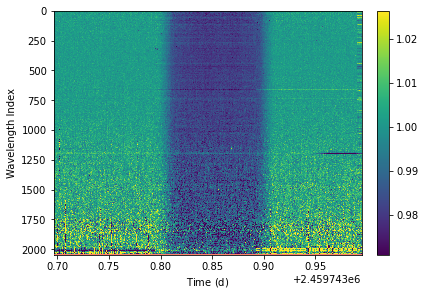

In [4]:
hatp18b = hatp18b.normalize()
hatp18b.imshow()

  0%|          | 0/469 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

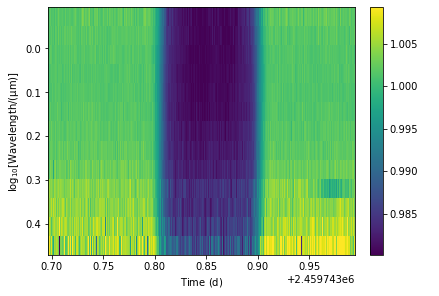

In [5]:
bin_hatp18b = hatp18b.bin(R=10)
bin_hatp18b.imshow()

  0%|          | 0/469 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

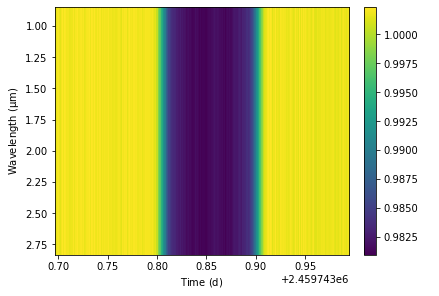

In [6]:
wlc_hatp18b = hatp18b.bin(nwavelengths=hatp18b.nwave)
wlc_hatp18b.imshow()

In [7]:
# wlc_hatp18b.flux[:,242:272] = np.nan

In [8]:
# wlc_hatp18b.flux[:,242:272]

In [9]:
# wlc_hatp18b.timelike['ok'] = np.array([True] * wlc_hatp18b.ntime)
# wlc_hatp18b.timelike['ok'][242:272] = False

  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='Relative Flux (+ offsets)'>

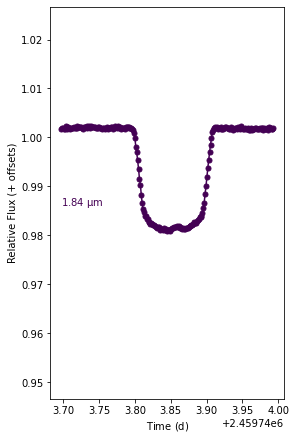

In [10]:
wlc_hatp18b.bin(ntimes=2).trim().plot()

In [11]:
np.nanmedian(wlc_hatp18b.uncertainty)

<Quantity 5.28527773e-05>

In [12]:
# star_temp = 4800 * u.K
# logg = 4.58765 
# metallicity = 0.0
# distance = 161 * u.pc
# radius = 0.7305 * u.Rsun

# spot_temp = 3596 * u.K

# # get the spectrum from the surface
# _, surface_flux = get_phoenix_photons(
#         temperature=u.Quantity(star_temp).value,
#         logg=logg,
#         metallicity=metallicity,
#         wavelength=bin_hatp18b.wavelength,
#     )

# # get the received flux at Earth
# received_flux = surface_flux * (radius / distance).decompose() ** 2

# # get the spectrum from the surface
# _, surface_flux_spot = get_phoenix_photons(
#         temperature=u.Quantity(spot_temp).value,
#         logg=logg,
#         metallicity=metallicity,
#         wavelength=bin_hatp18b.wavelength,
#     )

# # get the received flux at Earth
# received_flux_spot = surface_flux_spot * (radius / distance).decompose() ** 2

In [13]:
# plt.plot(bin_hatp18b.wavelength, received_flux, label=f'T={star_temp}')
# plt.plot(bin_hatp18b.wavelength, received_flux_spot, label=f'T={spot_temp}')
# plt.ylabel("Received Flux")
# plt.xlabel(f"Wavelength [{hatp18b.wavelength.unit}]")
# plt.legend()

In [14]:
# contrast = 1 - (received_flux_spot/received_flux)
# plt.plot(bin_hatp18b.wavelength,contrast)

In [15]:
t= wlc_hatp18b.time.to_value('d')
flux = wlc_hatp18b.flux[0]
sigma = wlc_hatp18b.uncertainty[0]

In [32]:
# map = starry.Map(ydeg=5)
# map.add_spot(amp=-0.075, sigma=0.1, lat=0, lon=-30)
# A_y = np.array(map.y[1:])

hatp18_params = dict(
    ydeg=35,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=88.8,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=0.74,  #  radius in R_sun
    m=0.773,  # mass in M_sun
    prot=14.66,  # rotational period in days
    u=[0.10, 0.1],  # limb darkening coefficients
#     y=A_y,  # the spherical harmonic coefficients
)


In [33]:
with pm.Model() as model1:

    # Primary
    star_theory = starry.Primary(
        starry.Map(ydeg=hatp18_params["ydeg"], udeg=hatp18_params["udeg"], amp=hatp18_params['amp'], inc=90),
        r=hatp18_params["r"],
        m=hatp18_params["m"],
        prot=hatp18_params["prot"],
#         inc=30,
        length_unit=u.R_sun,
        mass_unit=u.M_sun,
    )
    star_theory.map[1:] = hatp18_params["u"]
    
    star_theory.map.spot(contrast=0.58, radius=1, lat=-20, lon=-20)
    
    planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=62.610,  # mass in solar masses
    r=11.153,# radius
    inc=hatp18_params["inc"],
    length_unit=u.R_earth,
    mass_unit=u.M_earth,
    porb=5.508023,  # orbital period in days
    prot=5.508023,  # rotation period in days (synchronous)
    omega=120,  # longitude of ascending node in degrees
    ecc=0.084,  # eccentricity
#     w=120,  # longitude of pericenter in degrees
    t0=2459743.85,  # time of transit in days
    )

    # System
    sys = starry.System(star_theory, planet)

In [34]:
sys.show(t)
# star.map.show(theta=np.linspace(0, 360, 50))

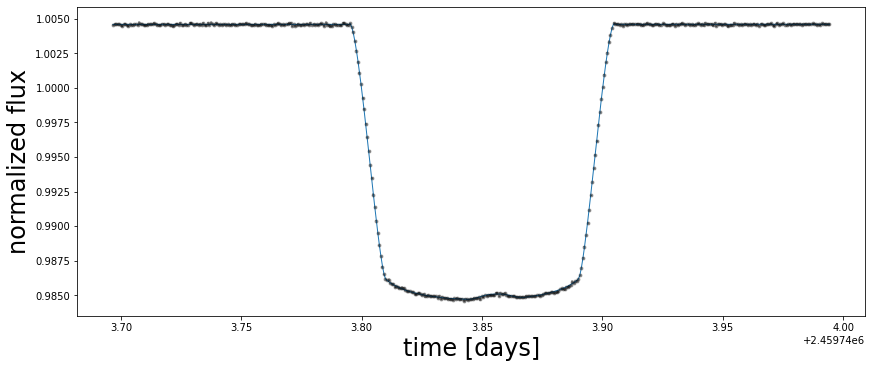

In [35]:
# t = np.linspace(-2.5, 2.5, 1000)
flux_true = eval_in_model(sys.flux(t), model=model1)
# flux_true = flux_true/np.nanmedian(flux_true)
# flux_true = eval_in_model(star.map.flux(theta=360*bin_hatp18b.time.to_value('d')/A["prot"]), model=model)
sigma = 5e-5
ferr = sigma * np.random.randn(len(t))
flux = flux_true + ferr

fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.3, ms=2)
plt.errorbar(t, flux, np.abs(ferr), c="k", fmt='.', alpha=0.3)
ax.plot(t, flux_true, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

In [36]:
# r = SimulatedRainbow(time=t*u.day, wavelength=wlc_hatp18b.wavelength)
# r.flux[:] = r.flux * flux
# r.uncertainty[:] = np.abs(ferr)
# r.imshow()

In [37]:
s.summary

NameError: name 's' is not defined

In [38]:
s = TransitSpotModel(ydeg=30)
s.setup_parameters(
    A = Fitted(Normal, mu=1.02, sigma=0.01),
    
    # stellar parameters
    rs=hatp18_params["r"], # stellar radius in Sun radius
    ms=hatp18_params["m"], # stellar mass in Sun masses
    prot=hatp18_params["prot"], # stellar rotation period
    u=[0.2514258,0.2977001],#Fitted(Normal, mu=[0.3,0.3], sigma=0.1, shape=2),#hatp18_params["u"], # limb-darkening coeffs
    stellar_inc = 90,#Fitted(Uniform, lower=0, upper=180, testval=90),
    
    # spot parameters
    spot_contrast = Fitted(Uniform,lower=0.0, upper=1.0, testval=0.5),
    spot_radius = Fitted(Uniform,lower=0.0, upper=50, testval=10.0),
    spot_latitude = Fitted(Uniform, lower=-90.0, upper=90, testval=-10),
    spot_longitude = Fitted(Uniform, lower=-90.0, upper=90, testval=-10),
    
    # planet parameters
    mp=Fitted(Normal, mu=62.66601, sigma=1), # planet mass in Earth masses
    rp=Fitted(Normal, mu=11.02560, sigma=0.002489),#mu=11.153, sigma=0.5), # planet radius in Earth radii
    inc=hatp18_params["inc"],
    period=5.508023,  # orbital period in days
    omega=Fitted(Normal, mu=156.1590, sigma=0.227423),  # longitude of ascending node in degrees
    ecc=0.084,  # eccentricity
    t0=Fitted(Normal, mu=2459743.8533670832, sigma=6.6778e-06)
#     t0=Fitted(Normal,mu=2459743.85, sigma=0.005),  # time of transit in days
#     amp=Fitted(Uniform, lower=0, upper=1, testval=5e-3)
)

In [39]:
s.summarize_parameters()

transitspot_A =
  <🧮 Fitted Normal(mu=1.02, sigma=0.01, name='transitspot_A') 🧮>

transitspot_rs =
  <🧮 Fixed | 0.74 🧮>

transitspot_ms =
  <🧮 Fixed | 0.773 🧮>

transitspot_stellar_amp =
  <🧮 Fixed | 1 🧮>

transitspot_stellar_inc =
  <🧮 Fixed | 90 🧮>

transitspot_prot =
  <🧮 Fixed | 14.66 🧮>

transitspot_u =
  <🧮 Fixed | [0.2514258, 0.2977001] 🧮>

transitspot_spot_contrast =
  <🧮 Fitted Uniform(lower=0.0, upper=1.0, testval=0.5, name='transitspot_spot_contrast') 🧮>

transitspot_spot_radius =
  <🧮 Fitted Uniform(lower=0.0, upper=50, testval=10.0, name='transitspot_spot_radius') 🧮>

transitspot_spot_latitude =
  <🧮 Fitted Uniform(lower=-90.0, upper=90, testval=-10, name='transitspot_spot_latitude') 🧮>

transitspot_spot_longitude =
  <🧮 Fitted Uniform(lower=-90.0, upper=90, testval=-10, name='transitspot_spot_longitude') 🧮>

transitspot_mp =
  <🧮 Fitted Normal(mu=62.66601, sigma=1, name='transitspot_mp') 🧮>

transitspot_rp =
  <🧮 Fitted Normal(mu=11.0256, sigma=0.002489, name='transitspot

In [40]:
s.attach_data(wlc_hatp18b.bin(ntimes=2))

  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
s.setup_lightcurves()

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0


In [42]:
# mask_spot = np.array([False] * s.data.ntime)
# mask_spot[121:136] = True
s.setup_likelihood()#inflate_uncertainties=True)#, mask_outliers=True, data_mask=[mask_spot])

In [51]:
print(s._pymc3_model)

                        transitspot_A ~ Normal
 transitspot_spot_contrast_interval__ ~ TransformedDistribution
   transitspot_spot_radius_interval__ ~ TransformedDistribution
 transitspot_spot_latitude_interval__ ~ TransformedDistribution
transitspot_spot_longitude_interval__ ~ TransformedDistribution
                       transitspot_mp ~ Normal
                       transitspot_rp ~ Normal
                    transitspot_omega ~ Normal
                       transitspot_t0 ~ Normal
            transitspot_spot_contrast ~ Uniform
              transitspot_spot_radius ~ Uniform
            transitspot_spot_latitude ~ Uniform
           transitspot_spot_longitude ~ Uniform
                                 data ~ Normal


In [44]:
s._pymc3_model.test_point

{'transitspot_A': array([1.02]),
 'transitspot_spot_contrast_interval__': array([0.]),
 'transitspot_spot_radius_interval__': array([-1.38629436]),
 'transitspot_spot_latitude_interval__': array([-0.22314355]),
 'transitspot_spot_longitude_interval__': array([-0.22314355]),
 'transitspot_mp': array([62.66601]),
 'transitspot_rp': array([11.0256]),
 'transitspot_omega': array([156.159]),
 'transitspot_t0': array([2459743.85336708])}

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

message: Desired error not necessarily achieved due to precision loss.
logp: -4003764.4816275565 -> -645.6992534761592
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

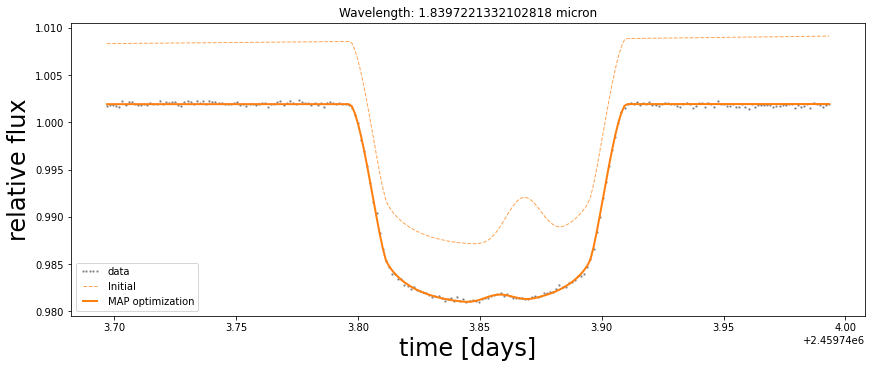

In [45]:
opt = s.optimize(plot=True)

In [46]:
opt

{'transitspot_A': array([0.99790167]),
 'transitspot_spot_contrast_interval__': array([-0.81038926]),
 'transitspot_spot_radius_interval__': array([-2.79747111]),
 'transitspot_spot_latitude_interval__': array([-0.43677014]),
 'transitspot_spot_longitude_interval__': array([-0.49136291]),
 'transitspot_mp': array([62.616942]),
 'transitspot_rp': array([11.00385356]),
 'transitspot_omega': array([158.33296939]),
 'transitspot_t0': array([2459743.85336797]),
 'transitspot_spot_contrast': array([0.30780755]),
 'transitspot_spot_radius': array([2.87304927]),
 'transitspot_spot_latitude': array([-19.34804719]),
 'transitspot_spot_longitude': array([-21.67694026])}

In [47]:
s.sample(start=opt,sampling_method=pmx.sample, draws=100, tune=100, chains=2, cores=1)#, return_inferencedata=True) #start=opt, 

Sampling model using the <function sample at 0x7f9f495d6670> method


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
/Users/catri

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 68630 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Can

                                       mean        sd       hdi_16%   
transitspot_A[0]               9.978903e-01  0.000032  9.978502e-01  \
transitspot_mp[0]              6.208127e+01  0.976618  6.114923e+01   
transitspot_rp[0]              1.100381e+01  0.001278  1.100291e+01   
transitspot_omega[0]           1.583291e+02  0.115432  1.581890e+02   
transitspot_t0[0]              2.459744e+06  0.000005  2.459744e+06   
transitspot_spot_contrast[0]   3.944300e-01  0.102582  2.922907e-01   
transitspot_spot_radius[0]     2.484548e+00  0.523661  1.896205e+00   
transitspot_spot_latitude[0]  -1.939961e+01  0.716155 -2.002044e+01   
transitspot_spot_longitude[0] -2.168133e+01  0.134187 -2.181621e+01   

                                    hdi_84%  mcse_mean   mcse_sd    ess_bulk   
transitspot_A[0]               9.979144e-01   0.000007  0.000005   22.288266  \
transitspot_mp[0]              6.313343e+01   0.421929  0.316290    6.623850   
transitspot_rp[0]              1.100547e+01   0.0

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0


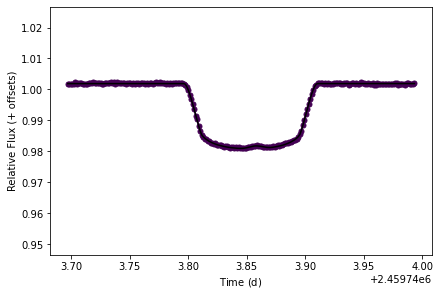

In [48]:
ax = s.plot_lightcurves(text=False)
# ax.set_ylim(0.865, 0.9)

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
🌈🤖 'systematics_model' doesn't exist and will be skipped.



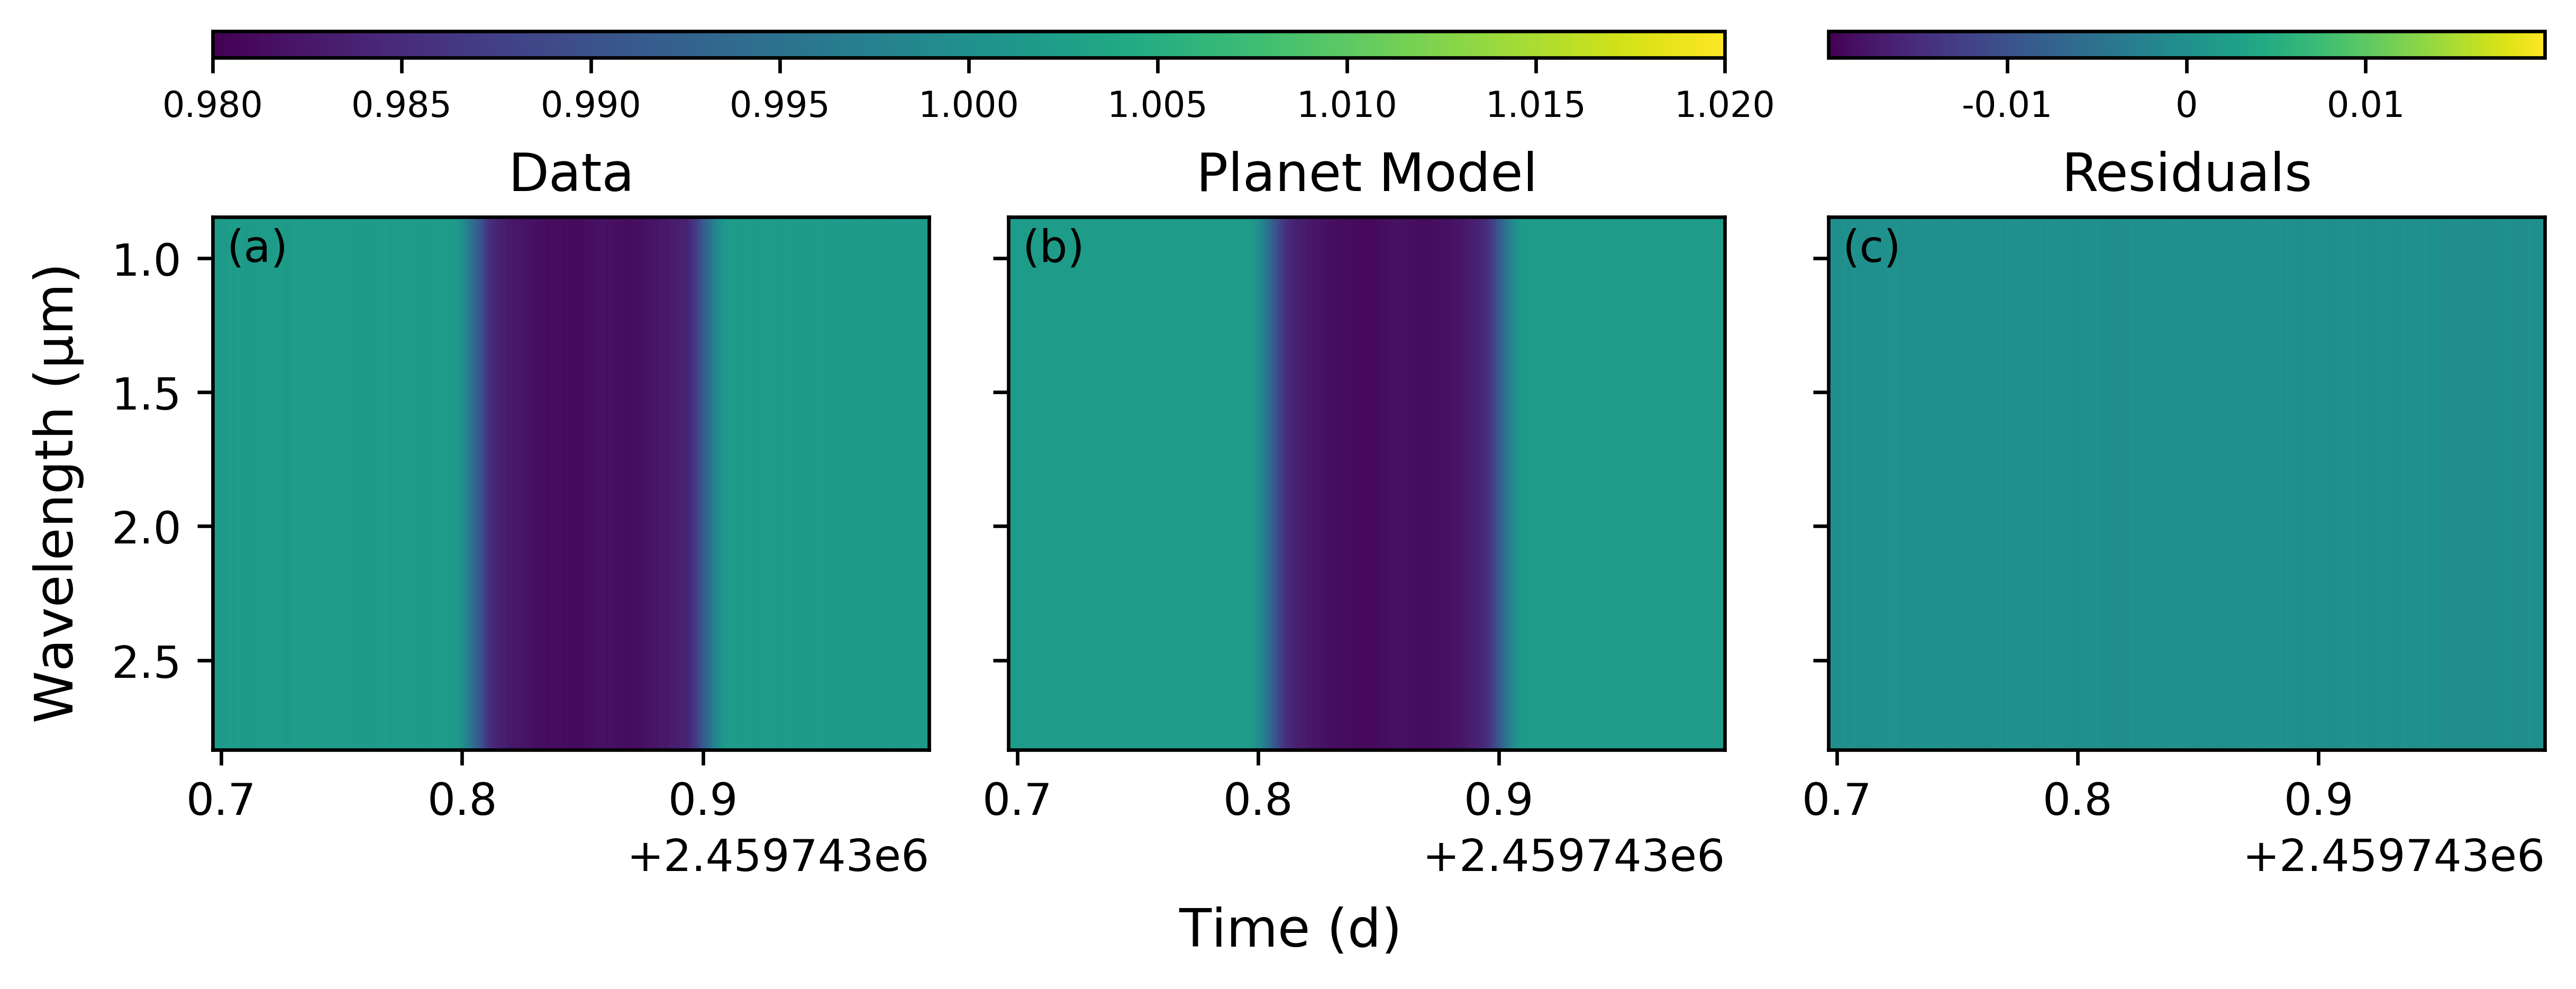

In [49]:
s.imshow_with_models()#vlimits_data=[0.87, 0.89])

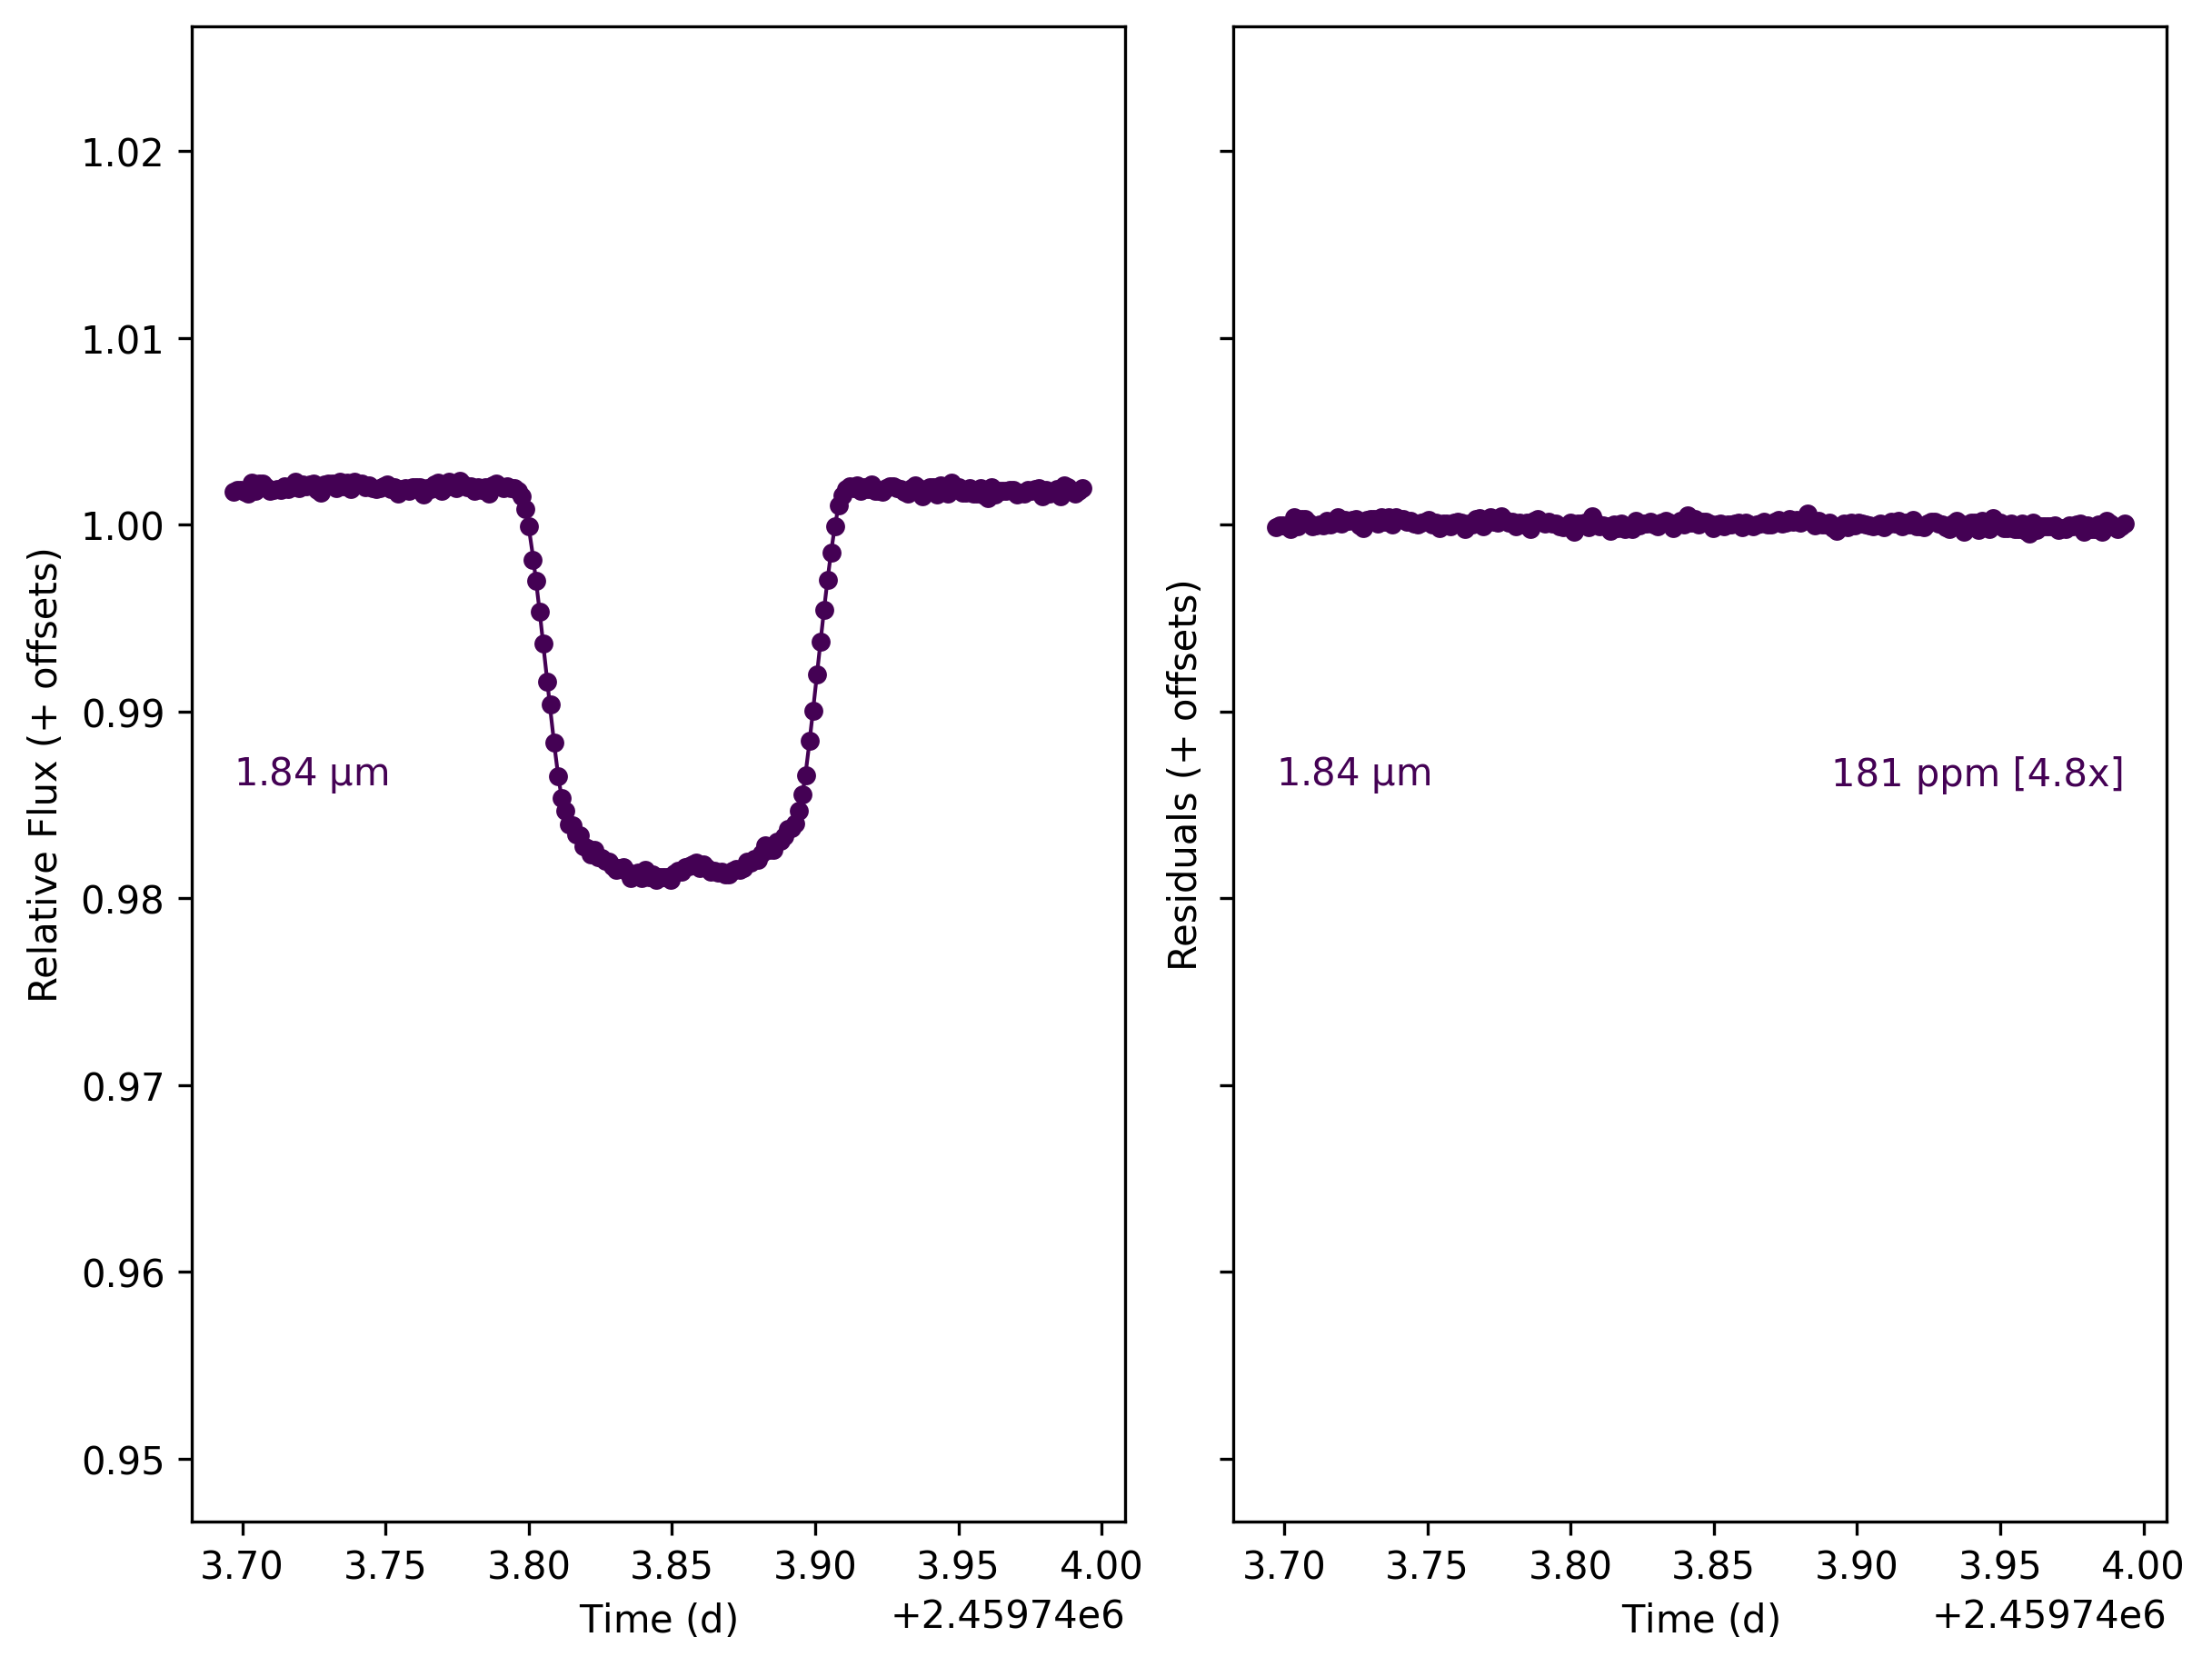

In [50]:
s.plot_with_model_and_residuals(histogram=False)

In [60]:
s.show(t=s.data.time)

In [73]:
s.keplerian_system

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (the

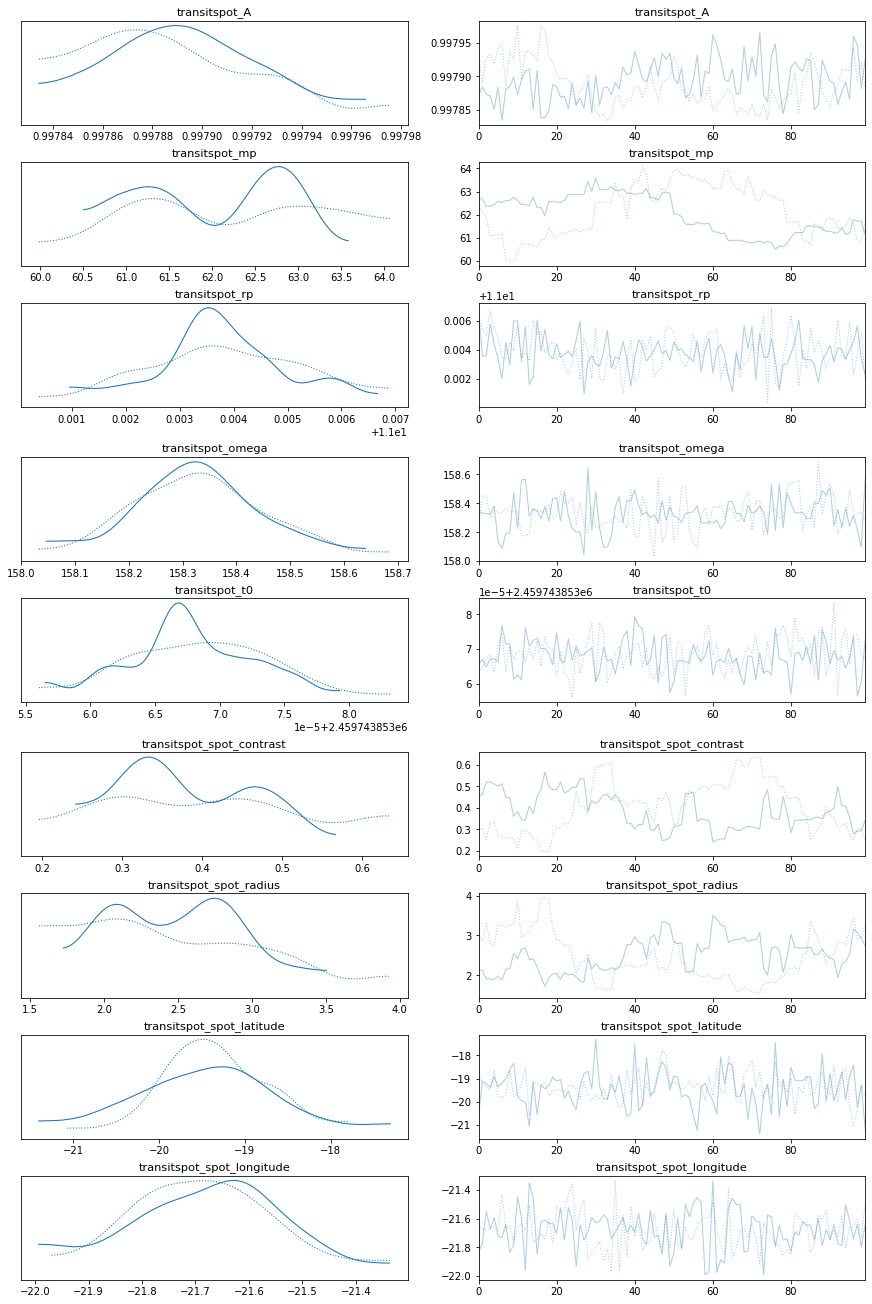

In [56]:
import arviz as az
with s._pymc3_model:
    az.plot_trace(s.trace)

In [26]:
results = s.get_results()
results.loc['w0']

transitspot_A                                          0.998054
transitspot_A_hdi_16%                                  0.998024
transitspot_A_hdi_84%                                  0.998074
transitspot_amp                                           0.005
transitspot_amp_hdi_16%                                   0.005
transitspot_amp_hdi_84%                                   0.005
transitspot_ecc                                           0.084
transitspot_ecc_hdi_16%                                   0.084
transitspot_ecc_hdi_84%                                   0.084
transitspot_inc                                            88.8
transitspot_inc_hdi_16%                                    88.8
transitspot_inc_hdi_84%                                    88.8
transitspot_mp                                         62.58023
transitspot_mp_hdi_16%                                61.677899
transitspot_mp_hdi_84%                                63.623392
transitspot_ms                          

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sqrt,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0


Too few points to create valid contours


/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/corner/core.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


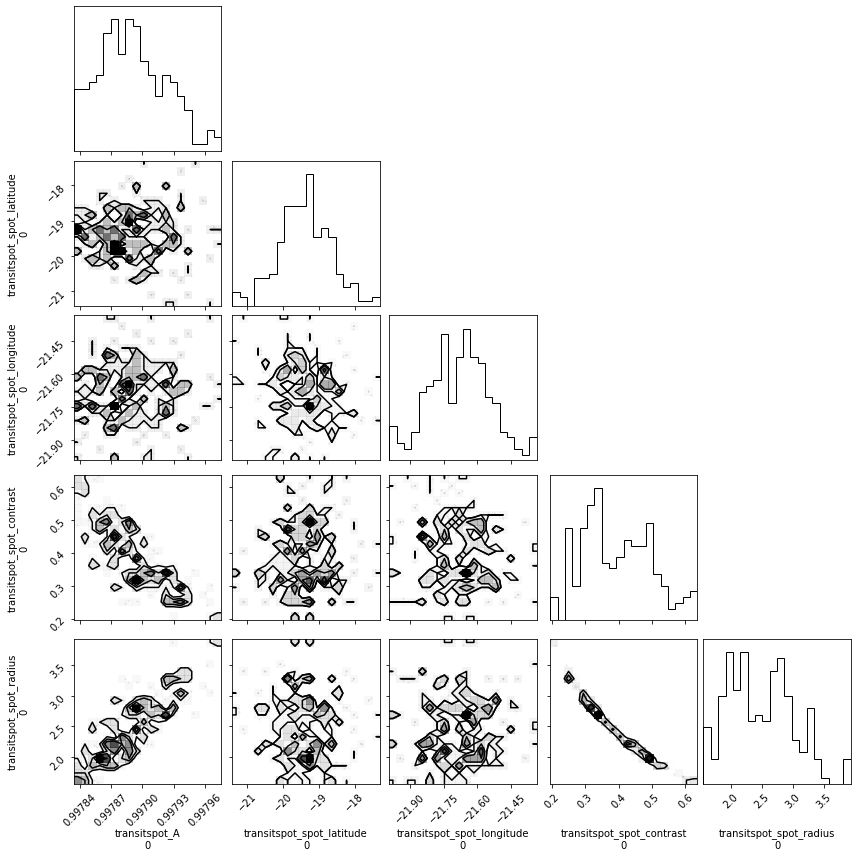

In [52]:
with s._pymc3_model:
    corner.corner(s.trace,
            var_names=[f'{s.name}_A',f'{s.name}_spot_latitude',
                                 f'{s.name}_spot_longitude',
                                 f'{s.name}_spot_contrast',
                                 f'{s.name}_spot_radius'],)
#                                  f'nsigma',],
#             truths=[1,0,0,0.6, 30,1])